In [1]:
import pandas as pd
import numpy as np
# import openai
# from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
import requests
import json
import re

import matplotlib.pyplot as plt
from collections import defaultdict
import random

from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

In [2]:
# read the data
duo_test_path = r'.\Duo'

cols = ['rating', 'year', 'perspective']
duo_pros = pd.read_excel(duo_test_path + "/duo_pros_topics.xlsx")[cols]
duo_pros['type'] = 'pros'

In [10]:
### Positive Perspective Coding

In [39]:
## Set up the LLM
llm = ChatOpenAI(
    model = "gemma2:27b", # need to pull it first 
    temperature = 0,
    max_tokens = None,
    timeout = None,
    max_retries = 2,
    api_key = "ollama",
    base_url="http://localhost:11434/v1"
    )

### Stage 1: Initial Code Generation

In [40]:
## Setting up prompts with PromptTemplate - Connection Test
# Prompt A
def llm_coder(ux_topic, user_review):
    prompt_template = PromptTemplate.from_template(

        """
        Your task is to classify user reviews into a single user experience topic based on the content of the review. 
        
        ### Instructions:
        1. **Topic Code**:
           - Generate a single-word topic code that captures the primary user experience or usability characteristic discussed in the review.
           - If the review fits a previously generated topic code, reuse that code.
           - If none of the existing codes apply, generate a new topic code that best represents the review.
           - If the review does not fit the user experience or usability topic, assign the code "None."
        
        2. **Examples**:
           - Review: 'suitable for learners of all ages even younger individuals interested in learning a new language'
             → Topic: [Inclusive]
           - Review: "The user sees big improvements in their learning process and uses the app daily, indicating its effectiveness"  
             → Topic: [Effectiveness]
           - Review: "Engaging interface for picking up a new language"  
             → Topic: [Engaging]

        3. **Output Format**:
           - Strictly format your response as:  
             Topic: Code
        
        4. **Previous Generated Topics**:
           - You must only choose from or add to the following list of previously generated topic codes:  
             {UX_code}
        
        ### Review:
        Here is the user review: {user_review}
        
        Provide your response below:
        
        """

        )

    ## Formatting
    prompts = prompt_template.format(UX_code = ux_topic,
                                    user_review = user_review)

    ## Call the model
    res = llm.invoke(prompts).content
    
    return res

In [2]:
def code_extract(text):
    match = re.search(r"Topic:\s*(\w+)", text)
    if match:
        word_after_topic = match.group(1)
    else:
        word_after_topic = 'None'
    return word_after_topic

In [44]:
# test
random_records = duo_pros['perspective'].sample(n=500, random_state=None).tolist()

topics = []
topics_cnt = {}
topics_dic = {}
uni_topic_num = []
pers_num = 0

for per in random_records:
    print('-----------')
    current_topics = ", ".join(list(set(topics)))
    topic = llm_coder(current_topics, per)
    topic = code_extract(topic)
    
    print("Perspective: ", per)
    print("Assigned Topic: ", topic)
    
    topics.append(topic) 
    
    if topic not in topics_dic:
        topics_dic[topic] = [per]
    else:
        topics_dic[topic].append(per)   
    
    if topic not in topics_cnt:
        topics_cnt[topic] = 1
    else:
        topics_cnt[topic] += 1
    
    uni_topic_num.append(len(set(topics)))
    pers_num += 1

-----------
Perspective:  the offers learning fictional languages like klingon and high valyrian which can be appealing for fans of specific franchises
Assigned Topic:  Content
-----------
Perspective:  fun and challenging tasks
Assigned Topic:  Engaging
-----------
Perspective:  great for learning words and basics of the language
Assigned Topic:  Content
-----------
Perspective:  detailed feedback on specific changes made in the new layout
Assigned Topic:  Content
-----------
Perspective:  high quality language learning with excellent graphics and animations
Assigned Topic:  Engaging
-----------
Perspective:  makes it easier to pass lessons and units quickly
Assigned Topic:  Effectiveness
-----------
Perspective:  introduction of the new learning pathway helps in staying organized and learning better
Assigned Topic:  Effectiveness
-----------
Perspective:  users appreciate the ability to learn multiple languages using the
Assigned Topic:  Content
-----------
Perspective:  appreciation

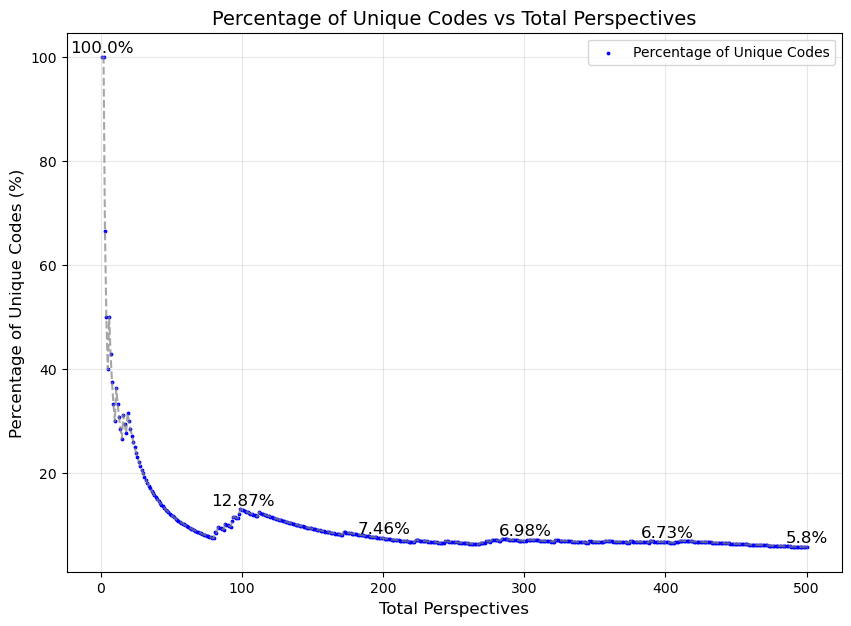

In [46]:
# Example data
x = list(range(1, len(uni_topic_num) + 1))
y = uni_topic_num

# Calculate percentages
percentages = [round(uni_code / total_pers * 100, 2) for total_pers, uni_code in zip(x, y)]

# Plot the dot plot
plt.figure(figsize=(10, 7))
plt.scatter(x, percentages, color='blue', s = 3, label = 'Percentage of Unique Codes')
plt.plot(x, percentages, linestyle='--', color='gray', alpha=0.7)  # Optional: Connect dots with a line for visualization

# Add labels and title
plt.xlabel('Total Perspectives', fontsize=12)
plt.ylabel('Percentage of Unique Codes (%)', fontsize=12)
plt.title('Percentage of Unique Codes vs Total Perspectives', fontsize=14)
plt.grid(alpha=0.3)  # Add a light grid
plt.legend()

# Annotate dots with percentages
for i, perc in enumerate(percentages):
    if (i%100 == 0) or (i == 499):
        plt.text(x[i], percentages[i] + 1, f"{perc}%", ha='center', fontsize=12)

# Show the plot
plt.show()

In [47]:
# Number of bootstraps and sample size
n_bootstraps = 100
sample_size = 100

# Initialize a list to store topics_dic from each bootstrap
all_topics_dic = []

# Bootstrapping
for bootstrap_idx in range(n_bootstraps):
    print(f"Bootstrap Iteration: {bootstrap_idx + 1}")
    
    # Randomly sample 100 perspectives
    random_records = duo_pros['perspective'].sample(n=sample_size, random_state=random.randint(0, 10000)).tolist()
    
    # Initialize variables for this bootstrap
    topics = []
    topics_dic = {}
    
    for per in random_records:
        current_topics = ", ".join(list(set(topics)))
        topic = llm_coder(current_topics, per)  # Call LLM coder
        topic = code_extract(topic)  # Extract the code from LLM response
        
        topics.append(topic)
        
        # Add perspective to topics_dic
        if topic not in topics_dic:
            topics_dic[topic] = [per]
        else:
            topics_dic[topic].append(per)
    
    # Save the topics_dic for this bootstrap iteration
    all_topics_dic.append(topics_dic)


Bootstrap Iteration: 1
Bootstrap Iteration: 2
Bootstrap Iteration: 3
Bootstrap Iteration: 4
Bootstrap Iteration: 5
Bootstrap Iteration: 6
Bootstrap Iteration: 7
Bootstrap Iteration: 8
Bootstrap Iteration: 9
Bootstrap Iteration: 10
Bootstrap Iteration: 11
Bootstrap Iteration: 12
Bootstrap Iteration: 13
Bootstrap Iteration: 14
Bootstrap Iteration: 15
Bootstrap Iteration: 16
Bootstrap Iteration: 17
Bootstrap Iteration: 18
Bootstrap Iteration: 19
Bootstrap Iteration: 20
Bootstrap Iteration: 21
Bootstrap Iteration: 22
Bootstrap Iteration: 23
Bootstrap Iteration: 24
Bootstrap Iteration: 25
Bootstrap Iteration: 26
Bootstrap Iteration: 27
Bootstrap Iteration: 28
Bootstrap Iteration: 29
Bootstrap Iteration: 30
Bootstrap Iteration: 31
Bootstrap Iteration: 32
Bootstrap Iteration: 33
Bootstrap Iteration: 34
Bootstrap Iteration: 35
Bootstrap Iteration: 36
Bootstrap Iteration: 37
Bootstrap Iteration: 38
Bootstrap Iteration: 39
Bootstrap Iteration: 40
Bootstrap Iteration: 41
Bootstrap Iteration: 42
B

In [48]:
# Merge all topics_dic from bootstrapping
merged_topics_dic = defaultdict(list)

for topics_dic in all_topics_dic:
    for topic, perspectives in topics_dic.items():
        merged_topics_dic[topic].extend(perspectives)

In [53]:
# Convert merged_topics_dic to a DataFrame for easier analysis
merged_topics_df = pd.DataFrame(
    [(topic, perspective) for topic, perspectives in merged_topics_dic.items() for perspective in perspectives],
    columns=["Topic", "Perspective"]
)

In [55]:
merged_topics_df = merged_topics_df[merged_topics_df['Topic']!= 'None']
merged_topics_df

,Topic,Perspective
477,ContentVariety,the addition of stories and audio lessons offe...
478,ContentVariety,balanced approach between learning hindi and g...
479,ContentVariety,great for learning french and introducing your...
480,ContentVariety,the wishes for more practice in conversations ...
481,ContentVariety,varied voices and characters multiple characte...
...,...,...
9995,Incentives,offers gems as rewards for meeting daily goals
9996,Incentives,levels can provide motivation to keep studying...
9997,Incentives,loyalty rewards system for consistent use of the
9998,Incentives,the option to watch ads for more hearts is a h...


### Stage 2: Code Refinement

In [59]:
codes = merged_topics_df['Topic'].value_counts().index.tolist()
codes = [code for code in codes if str(code) != 'nan']
all_codes_embeddings = [model.encode(code) for code in codes]

In [74]:
def pers_sim(test_perspective):
    test_perspective_embedding = model.encode(test_perspective)
    
    # Compute similarities
    similarities = [util.cos_sim(test_perspective_embedding, code_embedding).item()
                    for code_embedding in all_codes_embeddings]
    
    # Combine codes and their similarity scores
    codes_with_scores = list(zip(codes, similarities))
    
    # Sort by similarity in descending order
    sorted_codes = sorted(codes_with_scores, key=lambda x: x[1], reverse=True)
    
    # Display results
    if sorted_codes[0][1] > 0.3:
        return sorted_codes[0][0]
    else:
        return "Not pass"

'Simplicity'

In [75]:
# 2nd round coding
merged_topics_df['Topic_2nd_Rd'] = merged_topics_df['Perspective'].apply(pers_sim)

# if the similarity does not pass the cutoff, use the original code
merged_topics_df['Topic_2nd_Rd'] = np.where(merged_topics_df['Topic_2nd_Rd'] == 'Not pass', merged_topics_df['Topic'], merged_topics_df['Topic_2nd_Rd'])

# Concatenation
merged_topics_df['all_topics'] = np.where(merged_topics_df['Topic_2nd_Rd'] == merged_topics_df['Topic'], 
                                          merged_topics_df['Topic'], merged_topics_df['Topic_2nd_Rd'] + " " + merged_topics_df['Topic'])

C:\Users\lingc\AppData\Local\Temp\ipykernel_4156\709419237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_topics_df['Topic_2nd_Rd'] = merged_topics_df['Perspective'].apply(pers_sim)
C:\Users\lingc\AppData\Local\Temp\ipykernel_4156\709419237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_topics_df['Topic_2nd_Rd'] = np.where(merged_topics_df['Topic_2nd_Rd'] == 'Not pass', merged_topics_df['Topic'], merged_topics_df['Topic_2nd_Rd'])
C:\Users\lingc\AppData\Local\Temp\ipykernel_4156\70941

In [78]:
merged_topics_df.head()

,Topic,Perspective,Topic_2nd_Rd,all_topics
0,ContentVariety,the addition of stories and audio lessons offe...,Audio,Audio ContentVariety
1,ContentVariety,balanced approach between learning hindi and g...,ContentVariety,ContentVariety
2,ContentVariety,great for learning french and introducing your...,ContentVariety,ContentVariety
3,ContentVariety,the wishes for more practice in conversations ...,Communication,Communication ContentVariety
4,ContentVariety,varied voices and characters multiple characte...,Unique,Unique ContentVariety


### Stage 3: Kmeans Clustering with LLM summary chain

In [86]:
# Function to summarize a cluster using LLM
# Prompt B
def llm_summarize_cluster(cluster_codes):
    prompt_template = PromptTemplate.from_template(
        """
        Your task is to summarize the following topics into a single cohesive label:
        
        **Topics**:
        {cluster_codes}

        **Instructions**:
        - Summarize into a single topic label.
        - Be concise and specific.
        - Just return the label.
        
        Provide your response below:
        """
    )
    prompt = prompt_template.format(cluster_codes="\n".join(cluster_codes))
    response = llm.invoke(prompt).content
    return response.strip()

In [88]:
# Kmeans then LLM
codes = merged_topics_df['all_topics'].value_counts().index.tolist()
codes = [code for code in codes if str(code) != 'nan']
embeddings = [model.encode(code) for code in codes]

# Set range of cluster numbers to test
cluster_range = range(5, 12)  # From 5 to 12 clusters

# Dictionary to store cluster summaries
cluster_summaries = {}

for n_clusters in cluster_range:
    print(f"Running K-means with {n_clusters} clusters...")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Map codes to clusters 
    cluster_to_codes = {cluster: [] for cluster in range(n_clusters)}
    for code, label in zip(codes, cluster_labels):
        if len(cluster_to_codes[label]) < 20: 
            cluster_to_codes[label].append(code)
    
    # Summarize each cluster
    cluster_labels_summary = {}
    for cluster, cluster_codes in cluster_to_codes.items():
        summary = llm_summarize_cluster(cluster_codes)
        cluster_labels_summary[cluster] = summary
        print(f"Cluster {cluster} ({n_clusters} clusters): {summary}")
    
    # Store summaries for this number of clusters
    cluster_summaries[n_clusters] = cluster_labels_summary

Running K-means with 5 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (5 clusters): Accessible Language Learning
Cluster 1 (5 clusters): User Experience
Cluster 2 (5 clusters): Learner Engagement and Motivation
Cluster 3 (5 clusters): Learning Effectiveness
Cluster 4 (5 clusters): Accessible Design & Usability
Running K-means with 6 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (6 clusters): Accessible Learning Resources
Cluster 1 (6 clusters): User Engagement and Effectiveness
Cluster 2 (6 clusters): Learning Effectiveness
Cluster 3 (6 clusters): Product Feature Effectiveness & User Experience
Cluster 4 (6 clusters): Accessible Design & Usability
Cluster 5 (6 clusters): Motivation and Reinforcement Strategies
Running K-means with 7 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (7 clusters): Accessible Learning Resources
Cluster 1 (7 clusters): User Experience (UX)
Cluster 2 (7 clusters): Learning Effectiveness
Cluster 3 (7 clusters): Product Feedback and Improvement Systems
Cluster 4 (7 clusters): Accessible Design & Usability
Cluster 5 (7 clusters): Reward System Effectiveness
Cluster 6 (7 clusters): Engaging Learning Experience
Running K-means with 8 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (8 clusters): Accessible & Inclusive Learning Community
Cluster 1 (8 clusters): User Engagement
Cluster 2 (8 clusters): Learning Effectiveness
Cluster 3 (8 clusters): Convenience and Flexibility
Cluster 4 (8 clusters): Accessible Design & Implementation
Cluster 5 (8 clusters): Language Learning & Communication Effectiveness
Cluster 6 (8 clusters): Motivational Engagement and Effectiveness
Cluster 7 (8 clusters): Learning & Assessment Feedback Systems
Running K-means with 9 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (9 clusters): Accessible & Inclusive Social Learning Platform
Cluster 1 (9 clusters): Engaging Learning Experience
Cluster 2 (9 clusters): Program Effectiveness
Cluster 3 (9 clusters): User Experience  Convenience & Flexibility
Cluster 4 (9 clusters): Accessible Design & Usability
Cluster 5 (9 clusters): Language Learning Tools & Effectiveness
Cluster 6 (9 clusters): Motivation and Reward Effectiveness
Cluster 7 (9 clusters): Educational Feedback Systems
Cluster 8 (9 clusters): User Experience (UX)
Running K-means with 10 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (10 clusters): Accessible & Inclusive Educational Resources
Cluster 1 (10 clusters): Engaging Learning Experience
Cluster 2 (10 clusters): Effectiveness of Learning Interventions
Cluster 3 (10 clusters): User Experience
Cluster 4 (10 clusters): Accessible Design & Usability
Cluster 5 (10 clusters): Language Learning Tools & Effectiveness
Cluster 6 (10 clusters): Motivation and Reward Effectiveness
Cluster 7 (10 clusters): Feedback Systems
Cluster 8 (10 clusters): Inclusive and User-Centric Design
Cluster 9 (10 clusters): Learning & Retention Optimization
Running K-means with 11 clusters...


C:\Users\lingc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster 0 (11 clusters): Free and Accessible Advertising
Cluster 1 (11 clusters): Engaging Learning Experience
Cluster 2 (11 clusters): Effectiveness of Learning Interventions
Cluster 3 (11 clusters): User Experience Flexibility & Affordability
Cluster 4 (11 clusters): Accessible Design & Usability
Cluster 5 (11 clusters): Language Learning Tools & Effectiveness
Cluster 6 (11 clusters): Motivation and Reward Effectiveness
Cluster 7 (11 clusters): Platform Feedback and Engagement Features
Cluster 8 (11 clusters): Inclusive Learning Platform
Cluster 9 (11 clusters): Learning Effectiveness and Retention
Cluster 10 (11 clusters): Usability


In [89]:
# Display or export results
for n_clusters, summaries in cluster_summaries.items():
    print(f"\nCluster Summaries for {n_clusters} Clusters:")
    for cluster, summary in summaries.items():
        print(f"Cluster {cluster}: {summary}")


Cluster Summaries for 5 Clusters:
Cluster 0: Accessible Language Learning
Cluster 1: User Experience
Cluster 2: Learner Engagement and Motivation
Cluster 3: Learning Effectiveness
Cluster 4: Accessible Design & Usability

Cluster Summaries for 6 Clusters:
Cluster 0: Accessible Learning Resources
Cluster 1: User Engagement and Effectiveness
Cluster 2: Learning Effectiveness
Cluster 3: Product Feature Effectiveness & User Experience
Cluster 4: Accessible Design & Usability
Cluster 5: Motivation and Reinforcement Strategies

Cluster Summaries for 7 Clusters:
Cluster 0: Accessible Learning Resources
Cluster 1: User Experience (UX)
Cluster 2: Learning Effectiveness
Cluster 3: Product Feedback and Improvement Systems
Cluster 4: Accessible Design & Usability
Cluster 5: Reward System Effectiveness
Cluster 6: Engaging Learning Experience

Cluster Summaries for 8 Clusters:
Cluster 0: Accessible & Inclusive Learning Community
Cluster 1: User Engagement
Cluster 2: Learning Effectiveness
Cluster 3

Cluster Summaries for 5 Clusters:
Cluster 0: Accessible Language Learning
Cluster 1: User Experience
Cluster 2: Learner Engagement and Motivation
Cluster 3: Learning Effectiveness
Cluster 4: Accessible Design & Usability

Cluster Summaries for 6 Clusters:
Cluster 0: Accessible Learning Resources
Cluster 1: User Engagement and Effectiveness
Cluster 2: Learning Effectiveness
Cluster 3: Product Feature Effectiveness & User Experience
Cluster 4: Accessible Design & Usability
Cluster 5: Motivation and Reinforcement Strategies

Cluster Summaries for 7 Clusters:
Cluster 0: Accessible Learning Resources
Cluster 1: User Experience (UX)
Cluster 2: Learning Effectiveness
Cluster 3: Product Feedback and Improvement Systems
Cluster 4: Accessible Design & Usability
Cluster 5: Reward System Effectiveness
Cluster 6: Engaging Learning Experience

Cluster Summaries for 8 Clusters:
Cluster 0: Accessible & Inclusive Learning Community
Cluster 1: User Engagement
Cluster 2: Learning Effectiveness
Cluster 3: Convenience and Flexibility
Cluster 4: Accessible Design & Implementation
Cluster 5: Language Learning & Communication Effectiveness
Cluster 6: Motivational Engagement and Effectiveness
Cluster 7: Learning & Assessment Feedback Systems

Cluster Summaries for 9 Clusters:
Cluster 0: Accessible & Inclusive Social Learning Platform
Cluster 1: Engaging Learning Experience
Cluster 2: Program Effectiveness
Cluster 3: User Experience  Convenience & Flexibility
Cluster 4: Accessible Design & Usability
Cluster 5: Language Learning Tools & Effectiveness
Cluster 6: Motivation and Reward Effectiveness
Cluster 7: Educational Feedback Systems
Cluster 8: User Experience (UX)

Cluster Summaries for 10 Clusters:
Cluster 0: Accessible & Inclusive Educational Resources
Cluster 1: Engaging Learning Experience
Cluster 2: Effectiveness of Learning Interventions
Cluster 3: User Experience
Cluster 4: Accessible Design & Usability
Cluster 5: Language Learning Tools & Effectiveness
Cluster 6: Motivation and Reward Effectiveness
Cluster 7: Feedback Systems
Cluster 8: Inclusive and User-Centric Design
Cluster 9: Learning & Retention Optimization

Cluster Summaries for 11 Clusters:
Cluster 0: Free and Accessible Advertising
Cluster 1: Engaging Learning Experience
Cluster 2: Effectiveness of Learning Interventions
Cluster 3: User Experience Flexibility & Affordability
Cluster 4: Accessible Design & Usability
Cluster 5: Language Learning Tools & Effectiveness
Cluster 6: Motivation and Reward Effectiveness
Cluster 7: Platform Feedback and Engagement Features
Cluster 8: Inclusive Learning Platform
Cluster 9: Learning Effectiveness and Retention
Cluster 10: Usability


### Average Kappa Score for each clsuter codes

In [3]:
# Set up the LLM for "gemma2:9b"
gemma_llm = ChatOpenAI(
    model="gemma2:9b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key="ollama",
    base_url="http://localhost:11434/v1"
)

# Set up the LLM for "llama3.1"
llama_llm = ChatOpenAI(
    model="llama3.1",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key="ollama",
    base_url="http://localhost:11434/v1"
)

In [93]:
# Function to generate LLM prompt for a given cluster summary and classify reviews
# Prompt C
def llm_labeler(user_review, cluster_summaries, llm):
    cluster_descriptions = "\n".join(
        [f"{i}. {summary}" for i, summary in cluster_summaries.items()]
    )
    prompt_template = PromptTemplate.from_template(
        f"""
        Your task is to classify user reviews into the following UX or usability topic codes based on the descriptions provided:
        
        **Topic Codes**:
        {cluster_descriptions}

        **Output Format**:
           - Strictly format your response as:  
             Topic: code number
        
        ### Review:
        Here is the user review: {user_review}
        
        Provide your response below:
        """
    )
    prompts = prompt_template.format(user_review=user_review)
    res = llm.invoke(prompts).content
    return res

# Iterate through cluster summaries to classify reviews and calculate Cohen's Kappa
average_kappa_scores = {}

# Iterate over the cluster configurations
for n_clusters, summaries in cluster_summaries.items():
    print(f"\nCluster Summaries for {n_clusters} Clusters:")
    for cluster, summary in summaries.items():
        print(f"Cluster {cluster}: {summary}")
    
    # Store Kappa scores for this cluster configuration
    kappas = []

    for iteration in range(5):  # Repeat the process 5 times
        print(f"\nIteration {iteration + 1} for {n_clusters} clusters:")
        
        # Randomly sample 100 user reviews
        random_records = duo_pros['perspective'].sample(n=100, random_state=random.randint(0, 10000)).tolist()
        
        # Get topics from Gemma LLM
        gemma_topics = [
            code_extract(llm_labeler(per, summaries, gemma_llm)) for per in random_records
        ]
        
        # Get topics from Llama LLM
        llama_topics = [
            code_extract(llm_labeler(per, summaries, llama_llm)) for per in random_records
        ]
        
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(llama_topics, gemma_topics)
        kappas.append(kappa)
        print(f"Iteration {iteration + 1}: Cohen's Kappa = {kappa:.3f}")
    
    # Calculate the average Cohen's Kappa for this cluster configuration
    average_kappa = np.mean(kappas)
    average_kappa_scores[n_clusters] = kappas
    print(f"\nAverage Cohen's Kappa for {n_clusters} clusters: {average_kappa:.3f}")
    


Cluster Summaries for 5 Clusters:
Cluster 0: Accessible Language Learning
Cluster 1: User Experience
Cluster 2: Learner Engagement and Motivation
Cluster 3: Learning Effectiveness
Cluster 4: Accessible Design & Usability

Iteration 1 for 5 clusters:
Iteration 1: Cohen's Kappa = 0.587

Iteration 2 for 5 clusters:
Iteration 2: Cohen's Kappa = 0.494

Iteration 3 for 5 clusters:
Iteration 3: Cohen's Kappa = 0.546

Iteration 4 for 5 clusters:
Iteration 4: Cohen's Kappa = 0.397

Iteration 5 for 5 clusters:
Iteration 5: Cohen's Kappa = 0.668

Average Cohen's Kappa for 5 clusters: 0.538

Cluster Summaries for 6 Clusters:
Cluster 0: Accessible Learning Resources
Cluster 1: User Engagement and Effectiveness
Cluster 2: Learning Effectiveness
Cluster 3: Product Feature Effectiveness & User Experience
Cluster 4: Accessible Design & Usability
Cluster 5: Motivation and Reinforcement Strategies

Iteration 1 for 6 clusters:
Iteration 1: Cohen's Kappa = 0.484

Iteration 2 for 6 clusters:
Iteration 2: C

In [94]:
# Display final results
print("\nFinal Average Kappa Scores Across Cluster Configurations:")
for n_clusters, kappas in average_kappa_scores.items():
    print(f"Clusters: {n_clusters}, Average Cohen's Kappa: {np.mean(kappas):.3f}")


Final Average Kappa Scores Across Cluster Configurations:
Clusters: 5, Average Cohen's Kappa: 0.538
Clusters: 6, Average Cohen's Kappa: 0.486
Clusters: 7, Average Cohen's Kappa: 0.636
Clusters: 8, Average Cohen's Kappa: 0.682
Clusters: 9, Average Cohen's Kappa: 0.664
Clusters: 10, Average Cohen's Kappa: 0.630
Clusters: 11, Average Cohen's Kappa: 0.506


## Original Codes Kappa
0: **Learning Effectiveness**	

1: **Motivation and Engagement Features**	

2: **Feedback and Mistake-based Learning**	

3: **Enjoyable Learning Experience**	

4: **User-friendly Interface and Design**	

5: **Exercises and Practice Activities**	

6: **Accessibility and Ease of Use**	

7: **Diverse Learning Resources**

In [7]:
# Manual Deciding the Optimal Codes
# Function to generate LLM prompt for a given cluster summary and classify reviews
def llm_labeler(user_review, llm):
    prompt_template = PromptTemplate.from_template(
        f"""
        Your task is to classify user reviews into the following UX or usability topic codes based on the descriptions provided:
        
        **Topic Codes**:
            0: **Learning Effectiveness**	
            1: **Motivation and Engagement Features**	
            2: **Feedback and Mistake-based Learning**	
            3: **Enjoyable Learning Experience**	
            4: **User-friendly Interface and Design**	
            5: **Exercises and Practice Activities**	
            6: **Accessibility and Ease of Use**	
            7: **Diverse Learning Resources**

        **Output Format**:
           - Strictly format your response as:  
             Topic: code number
        
        ### Review:
        Here is the user review: {user_review}
        
        Provide your response below:
        """
    )
    prompts = prompt_template.format(user_review=user_review)
    res = llm.invoke(prompts).content
    return res

# Store Kappa scores for this cluster configuration
kappas = []

for iteration in range(5):  # Repeat the process 5 times
    print(f"\nIteration {iteration + 1} for original themes:")
    
    # Randomly sample 100 user reviews
    random_records = duo_pros['perspective'].sample(n=100, random_state=random.randint(0, 10000)).tolist()
    
    # Get topics from Gemma LLM
    gemma_topics = [
        code_extract(llm_labeler(per, gemma_llm)) for per in random_records
    ]
    
    # Get topics from Llama LLM
    llama_topics = [
        code_extract(llm_labeler(per, llama_llm)) for per in random_records
    ]
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(llama_topics, gemma_topics)
    kappas.append(kappa)
    print(f"Iteration {iteration + 1}: Cohen's Kappa = {kappa:.3f}")

# Calculate the average Cohen's Kappa for this cluster configuration
average_kappa = np.mean(kappas)
print(f"\nAverage Cohen's Kappa for original themes: {average_kappa:.3f}")


Iteration 1 for original themes:
Iteration 1: Cohen's Kappa = 0.540

Iteration 2 for original themes:
Iteration 2: Cohen's Kappa = 0.612

Iteration 3 for original themes:
Iteration 3: Cohen's Kappa = 0.590

Iteration 4 for original themes:
Iteration 4: Cohen's Kappa = 0.544

Iteration 5 for original themes:
Iteration 5: Cohen's Kappa = 0.563

Average Cohen's Kappa for original themes: 0.570
